In [1]:
#import os
#os.environ["MKL_THREADING_LAYER"]="GNU"
#os.environ["MKL_NUM_THREADS"] = "1" 
#os.environ["NUMEXPR_NUM_THREADS"] = "1" 
#os.environ["OMP_NUM_THREADS"] = "1" 
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft
import theano.tensor.signal.conv

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[maskJ], delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), magerr_ref1[maskJ],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
#J band data
xJ=np.asarray(mjd_obs[maskJ], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), dtype=float)
yJerr = np.array(magerr_ref1[maskJ], dtype=float)

#H band data
maskH = (filt == 'H')

xHtemp=np.asarray(mjd_obs[maskH], dtype=float)
xH=np.delete(xHtemp,(1,2))
nH=len(xH)
XH = np.reshape(xH,(nH,1))
XH_new=np.linspace(min(XH),max(XH),100,dtype=np.float64)

Hdelta_mag_agn_ref1=np.delete(delta_mag_agn_ref1[maskH],(1,2))
yH=np.asarray(Hdelta_mag_agn_ref1-np.median(Hdelta_mag_agn_ref1), dtype=float)
yHerrtemp = np.asarray(magerr_ref1[maskH], dtype=float)
yHerr=np.delete(yHerrtemp,(1,2))

#K band data
maskK = (filt == 'K')
xK=np.asarray(mjd_obs[maskK], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK]-np.median(delta_mag_agn_ref1[maskK]), dtype=float)
yKerr = np.asarray(magerr_ref1[maskK], dtype=float)

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK),axis=None)
Y_tot=np.reshape(Y_tot,(len(Y_tot),1))

#time delay array
ntau=99
tau=np.linspace(0.0,100.0,ntau)
#tau=np.reshape(tau,(1,1,ntau,1))

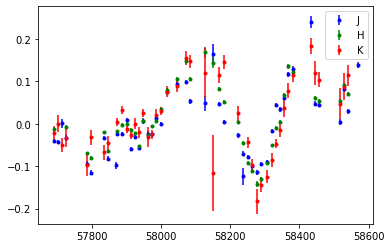

In [3]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='g.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='r.',label='K')
plt.legend()

In [4]:
#Interpolation function used in model to obtain comparison points with data 
def interpolate(x0, y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [ ]:
with pm.Model() as convmodel:
    
    #define driving function as Gaussian Process
    #find way to use g band as first guess of value 
    #what is the variation timescale of the driving function???
    ℓ = pm.Bound(pm.Normal, lower=1.0)('ℓ', mu=75.0, sigma=25.0)#pm.Uniform('ℓ', lower=1.0, upper=2.0*70.0)#pm.Bound(pm.Normal, lower=1.2574, upper=3.0*50.0*np.sqrt(2.0))('ℓ', mu=70.0, sigma=35.0)#timescale of variation for the driving function
    η = pm.Uniform('η', lower=0.0, upper=2.0)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#using same cov as light curve interpolation
    #const_func = pm.gp.mean.Constant(tt.mean(yJ))#long term mean. Should it be zero or the g-band value?
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_tot)#has all time values for all bands, testval is for g-band diffmag values?
    f = f.reshape((1,1,len(X_tot),1))
    #print(len(f.tag.test_value[0,0,:,0]))
    #print(f.tag.test_value)
    
    
    #Define priors
    
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.Uniform('sigma_DT', lower=tt.log(1.1), upper=tt.log(30.0))#needs a source for scale
    m_DT=pm.Uniform('m_DT', lower=10.0, upper=150.0)#we expect serveral tens to hundreds of days
    theta_DT=pm.Normal('theta_DT',mu=0,sigma=25.0)#pm.Uniform('theta_DT', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later when simple model is staple
    
    #Accretion Disk paramters
    Jsigma_AD=pm.Uniform('Jsigma_AD', lower=tt.log(1.1), upper=tt.log(30.0))#needs a source for scale
    Jm_AD=pm.Uniform('Jm_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT 
    Jtheta_AD=pm.Normal('Jtheta_AD',mu=0,sigma=25.0)#pm.Uniform('Jtheta_AD', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later 
   
    Hsigma_AD=pm.Uniform('Hsigma_AD', lower=tt.log(1.1), upper=tt.log(30.0))#needs a source for scale
    Hm_AD=pm.Uniform('Hm_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT
    Htheta_AD=pm.Normal('Htheta_AD',mu=0,sigma=25.0)#pm.Uniform('Htheta_AD', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later 
    
    Ksigma_AD=pm.Uniform('Ksigma_AD', lower=tt.log(1.1), upper=tt.log(30.0))#needs a source for scale
    Km_AD=pm.Uniform('Km_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT
    Ktheta_AD=pm.Normal('Ktheta_AD',mu=0,sigma=25.0)#pm.Uniform('Ktheta_AD', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later 
    
    #BB and power law parameters
    T=pm.Uniform('T', lower=tt.log(1000.0), upper=tt.log(2000.0))#pm.Bound(pm.Normal, lower=1000.0, upper=2000.0)('T', mu=1400.0, sigma=100.0)#taken from nature letter
    K_0=pm.Uniform('K_0', lower=0.0, upper=10.0)#is it BB/powr or powr/BB?
    index=pm.Normal('index', mu=1.5, sigma=0.5)#pm.Uniform('index', lower=0.0, upper=3.0)#sign depends on diffmag definition change to -2 to -1 for final?

    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm NEED DATASHEET
    Jwav=1250.0
    Hwav=1625.0
    Kwav=2150.0
    #Sloan filters for ROSS2 in nm
    #gwav=475.4
    #rwav= 620.4
    #iwav=769.8
    #zwav=966.5
    

    #Define constants 
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/tt.exp(T)
    b_max = 4.967#h*c/(1e-9*wav_peak*k*tt.exp(T))
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*tt.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*tt.exp(T))
    JBB = (1.0/( Jwav**5 * (tt.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    
    #Dusty Torus transfer equation for H band
    Hb = h*c/(1e-9*Hwav*k*tt.exp(T))
    HBB = (1.0/( Hwav**5 * (tt.exp(Hb) - 1.0) ))/BB_max
    HPsi_DT = HBB*lognorm_DT
    
    #Dusty Torus transfer equation for K band
    Kb = h*c/(1e-9*Kwav*k*tt.exp(T))
    KBB = (1.0/( Kwav**5 * (tt.exp(Kb) - 1.0) ))/BB_max
    KPsi_DT = KBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((tt.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*tt.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    Jlognorm_AD = tt.switch(tt.isnan(Jlognorm_AD), 0.0, Jlognorm_AD)
    JPsi_AD = Jpowr*Jlognorm_AD
    
    #Accretion Disk transfer equation for the H band
    Hpowr = K_0*(Hwav/wav_0)**(index)    
    Hexp_AD = -((tt.log((tau-Htheta_AD)/Hm_AD))**2/(2*Hsigma_AD**2))
    Hfront_AD = 1.0/((tau-Htheta_AD)*Hsigma_AD*tt.sqrt(2*np.pi))
    Hlognorm_AD = Hfront_AD*tt.exp(Hexp_AD)
    Hlognorm_AD = tt.switch(tt.isnan(Hlognorm_AD), 0.0, Hlognorm_AD)
    HPsi_AD = Hpowr*Hlognorm_AD
    
    #Accretion Disk transfer equation for the K band
    Kpowr = K_0*(Kwav/wav_0)**(index)    
    Kexp_AD = -((tt.log((tau-Ktheta_AD)/Km_AD))**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/((tau-Ktheta_AD)*Ksigma_AD*tt.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*tt.exp(Kexp_AD)
    Klognorm_AD = tt.switch(tt.isnan(Klognorm_AD), 0.0, Klognorm_AD)
    KPsi_AD = Kpowr*Klognorm_AD
    
    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    Htransfer = HPsi_DT + HPsi_AD
    Ktransfer = KPsi_DT + KPsi_AD
    
    #The convolutions
    #filter needs to be odd so tau is odd
    Jconvol=theano.tensor.nnet.conv2d(f[:,:,0:len(xJ),:],Jtransfer,border_mode='half')
    Hconvol=theano.tensor.nnet.conv2d(f[:,:,len(xJ):len(xJ)+len(xH),:],Htransfer,border_mode='half')
    Kconvol=theano.tensor.nnet.conv2d(f[:,:,len(xJ)+len(xH):len(xJ)+len(xH)+len(xK),:],Ktransfer,border_mode='half')
    #THIS NEEDS TO BE -1 FOR THE ARRAYS!!!
    #print(Hconvol.tag.test_value)
    #Define likelihoods
    #k = pm.Uniform('k', lower=1.0, upper=10.0)#Noise boost factor 
    Jlikelihood = pm.Normal('yJ', mu=Jconvol[0,0,:,0], sigma=yJerr, observed=yJ)
    Hlikelihood = pm.Normal('yH', mu=Hconvol[0,0,:,0], sigma=yHerr, observed=yH)
    Klikelihood = pm.Normal('yK', mu=Kconvol[0,0,:,0], sigma=yKerr, observed=yK)
    #the shape of mu and observed needs to be the same 
    
    tracetransfer = pm.sample(4000,tune=1000,init='advi+adapt_diag',chains=2,cores=8)

In [ ]:
names=['index', 'K_0','T', 'Ktheta_AD', 'Km_AD', 'Ksigma_AD', 'Htheta_AD', 'Hm_AD', 'Hsigma_AD', 'Jtheta_AD', 'Jm_AD', 'Jsigma_AD', 'theta_DT', 'm_DT', 'sigma_DT', 'η', 'ℓ']
# display the total number and percentage of divergent
divergent = tracetransfer['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = (divergent.nonzero()[0].size / (2*len(tracetransfer))) * 100
print('Percentage of Divergent %.1f' % divperc)

In [ ]:
pm.summary(tracetransfer,names).round(2)

In [ ]:
pm.traceplot(tracetransfer, var_names=names);

In [ ]:
pm.plot_posterior(tracetransfer,names)

In [ ]:
pm.pairplot(trace1transfer, var_names=names, divergences=True);

In [ ]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, tracetransfer["f"], X_tot);

# plot the data and the true latent function
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("f(x)");
plt.title("Driving function");

In [ ]:
n_new = 100
X_new = X_tot#np.linspace(min(X_tot), max(X_tot), n_new)

# add the GP conditional to the model, given the new X values
with convmodel:
    f_tot = gp.conditional("f_tot", X_new)

# Sample from the GP conditional distribution
with convmodel:
    pred_samples = pm.sample_posterior_predictive(tracetransfer, vars=[f_tot], samples=10000)

In [ ]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_tot"], X_new);
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("f(X)");
plt.title("Conditional distribution of f_*, given f");

In [ ]:
#Calculate the mean and standard deviation of the traces. 
mu = np.zeros(len(X_new))
sd = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu[i] = np.mean(pred_samples["f_tot"][:,i])
    sd[i] = np.std(pred_samples["f_tot"][:,i])

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
#plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
#plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
#plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)
plt.errorbar(X_tot,mu,sd,fmt='r.',label='Driving function value at data points')

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
#plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();
print(np.mean(sd))

In [ ]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='g.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='r.',label='K')
plt.errorbar(X_tot,mu,sd,fmt='k.',label='Driving')
plt.legend()

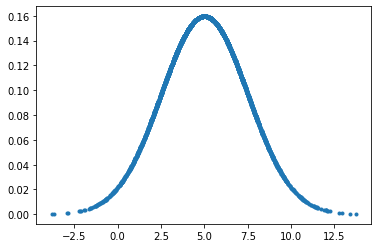

In [6]:
import numpy as np
import matplotlib.pyplot as plt

mu,sigma,n = 5,2.5,3000

def normal(x,mu,sigma):
    return ( 2.*np.pi*sigma**2. )**-.5 * np.exp( -.5 * (x-mu)**2. / sigma**2. )

x = np.random.normal(mu,sigma,n) 
y = normal(x,mu,sigma) 
y_log=normal(np.log(x),mu,sigma)

plt.plot(x,y,'.')


# Specify simple model to save time 

In [8]:
#locate index of points closest to data in conditional
n_new = 49
X_new = np.linspace(min(XJ), max(XJ), n_new)
idx=np.zeros(len(XJ),int)

for i in range(len(XJ)):
    idx[i] = np.argmin(((X_new - XJ[i])**2))
    
X_new[idx]-XJ
#idx

nf = 99
Xf = np.linspace(min(XJ), max(XJ), nf)
print((XJ[-1]-XJ[0])/3)

[293.07465733]


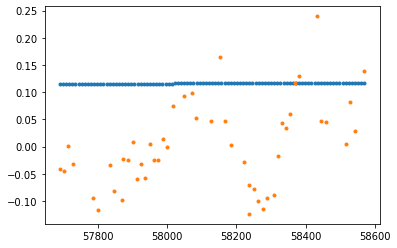

In [9]:
plt.plot(Xf,2e-6*Xf,'.')
plt.plot(XJ,yJ,'.')

In [10]:
with pm.Model() as simpleconvmodel:
    
    #define driving function as Gaussian Process
    #find way to use g band as first guess of value 
    #what is the variation timescale of the driving function???
    ℓ = pm.Bound(pm.Normal, lower=0.5)('ℓ',mu=2.0,sigma=1.0)#timescale of variation for the driving function, order of days for x-ray
    #REMEMBER time scale is 2*ℓ^2 so remember to rewrite as ℓ_true=2*ℓ^2
    η = pm.Uniform('η', lower=2.0, upper=10.0)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#using same cov as light curve interpolation
    #const_func = pm.gp.mean.Constant(tt.mean(yJ))#long term mean. Should it be zero or the g-band value?
    gp = pm.gp.Latent(cov_func=cov)
    
    #define "anchor points" using gp prior 

    f = gp.prior("f", X=Xf)#has all time values for all bands, testval is for g-band diffmag values?
    f = f.reshape((1,1,len(Xf),1))
    
    #create conditional distribution to find comparison points
    #f_sim = gp.conditional("f_sim", XJ)
    #fJ = f_sim#pm.sample_posterior_predictive(tracesimple, vars=[f_sim], samples=1)#f_sim
    #fJ=fJ.reshape((1,1,len(X_new),1))
    #print(fJ.tag.test_value)
    
    #Define priors
    
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.Bound(pm.Normal, lower=0.0)('sigma_DT',mu=2.0,sigma=2.0)#pm.Uniform('sigma_DT', lower=tt.log(1.01), upper=tt.log(30.0))#needs a source for scale
    m_DT=pm.Uniform('m_DT', lower=20.0, upper=75.0)#we expect serveral tens to hundreds of days from the nature letter
    theta_DT=pm.Uniform('theta_DT', lower=0.0, upper=np.max(tau)/1.2)#add later when simple model is staple
    
    #Accretion Disk paramters
    Jsigma_AD=pm.Bound(pm.Normal, lower=0.0)('Jsigma_AD',mu=2.0,sigma=2.0)# Shappee 2014 suggests somewhere between 0-30 days so log that 
    Jtheta_AD=pm.Normal('Jtheta_AD',mu=0.0,sigma=50.0)#pm.Uniform('Jtheta_AD', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later 
    Jm_lower=((m_DT+theta_DT)/5.0)-Jtheta_AD
    Jm_upper=((m_DT+theta_DT)/3.0)-Jtheta_AD
    Jm_AD=pm.Uniform('Jm_AD', lower=Jm_lower, upper=Jm_upper)#AD has 3-5 times smaller lags than DT 
    
    #BB and power law parameters
    T=pm.Bound(pm.Normal, lower=tt.log(1000.0), upper=tt.log(2300.0))('T', mu=tt.log(1400.0), sigma=0.22)#pm.Uniform('T', lower=tt.log(1000.0), upper=tt.log(2000.0))#pm.Bound(pm.Normal, lower=1000.0, upper=2000.0)('T', mu=1400.0, sigma=100.0)#taken from nature letter
    K_0=pm.Bound(pm.Normal, lower=0.0)('K_0',mu=5.0,sigma=5.0)#pm.Uniform('K_0', lower=0.0, upper=10.0)#is it BB/powr or powr/BB?
    index=pm.Normal('index', mu=1.5, sigma=0.5)#sign depends on diffmag definition change to -2 to -1 for final?
    #Note for index: we have taken the transformation from F_nu to F_lamb into account with the index value.

    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm NEED DATASHEET
    Jwav=1250.0
    
    #Define constants 
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/tt.exp(T)
    b_max = 4.967#h*c/(1e-9*wav_peak*k*tt.exp(T))
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*tt.exp(T))
    JBB = (1.0/( Jwav**5 * (tt.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((tt.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    Jlognorm_AD = tt.switch(tt.isnan(Jlognorm_AD), 0.0, Jlognorm_AD)
    JPsi_AD = Jpowr*Jlognorm_AD

    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    Jtransfer = Jtransfer.reshape(((1,1,len(tau),1)))
    #The convolutions
    #filter needs to be odd so tau is odd
    Jconvol=theano.tensor.nnet.conv2d(f[:,:,:,:],Jtransfer,border_mode='half')
    ######################################################################
    #'half': pad input with a symmetric border of filter rows // 2
    #rows and filter columns // 2 columns, then perform a valid convolution. 
    #For filters with an odd number of rows and columns, 
    #this leads to the output shape being equal to the input shape.
    ######################################################################
    
    #locate comparison points through interpolation
    comp=interpolate(Xf[:,0],Jconvol[0,0,:,0],XJ[:,0])
    
    #Define likelihood
    #k = pm.Uniform('k', lower=1.0, upper=10.0)#Noise boost factor 
    Jlikelihood = pm.Normal('yJ', mu=comp, sigma=yJerr, observed=yJ)
    
    #the shape of mu and observed needs to be the same 
    
    #max_treedepth, default=10
    #The maximum tree depth. Trajectories are stopped when this depth is reached.
    #early_max_treedepth, default=8
    #The maximum tree depth during the first 200 tuning samples.

    tracesimple = pm.sample(4000,tune=1000,init='advi+adapt_diag',chains=2,cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
  0%|          | 0/200000 [00:00<?, ?it/s]/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 490.68:  17%|█▋        | 33357/200000 [01:23<06:57, 399.45it/s]   
Convergence achieved at 33400
Interrupted at 33,399 [16%]: Average Loss = 40,587
/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differen

In [11]:
simplenames=['sigma_DT','m_DT','theta_DT','Jsigma_AD','Jtheta_AD','Jm_AD','T','K_0','index', 'η', 'ℓ']
summ=pm.summary(tracesimple,simplenames)
#print(summ.loc[:,'mean'])
summ

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_DT,1.735,1.613,0.062,4.824,0.981,0.786,3.0,3.0,3.0,38.0,1.93
m_DT,53.410,13.602,31.046,74.926,1.180,0.855,133.0,127.0,126.0,213.0,1.02
theta_DT,66.814,9.252,49.347,83.282,1.116,0.861,69.0,58.0,57.0,95.0,1.59
Jsigma_AD,3.005,1.417,0.553,5.498,0.306,0.220,21.0,21.0,23.0,171.0,1.08
Jtheta_AD,-65.121,37.180,-125.097,-4.029,16.810,12.678,5.0,5.0,5.0,39.0,1.35
Jm_AD,97.101,37.610,29.948,158.503,16.706,12.568,5.0,5.0,5.0,45.0,1.33
T,7.205,0.207,6.908,7.578,0.098,0.074,4.0,4.0,4.0,51.0,1.40
K_0,5.757,3.677,0.326,12.155,1.327,0.977,8.0,8.0,7.0,52.0,1.21
index,1.511,0.505,0.571,2.470,0.035,0.025,208.0,203.0,210.0,517.0,1.01
η,5.298,2.109,2.029,9.084,0.221,0.157,91.0,91.0,86.0,110.0,1.04


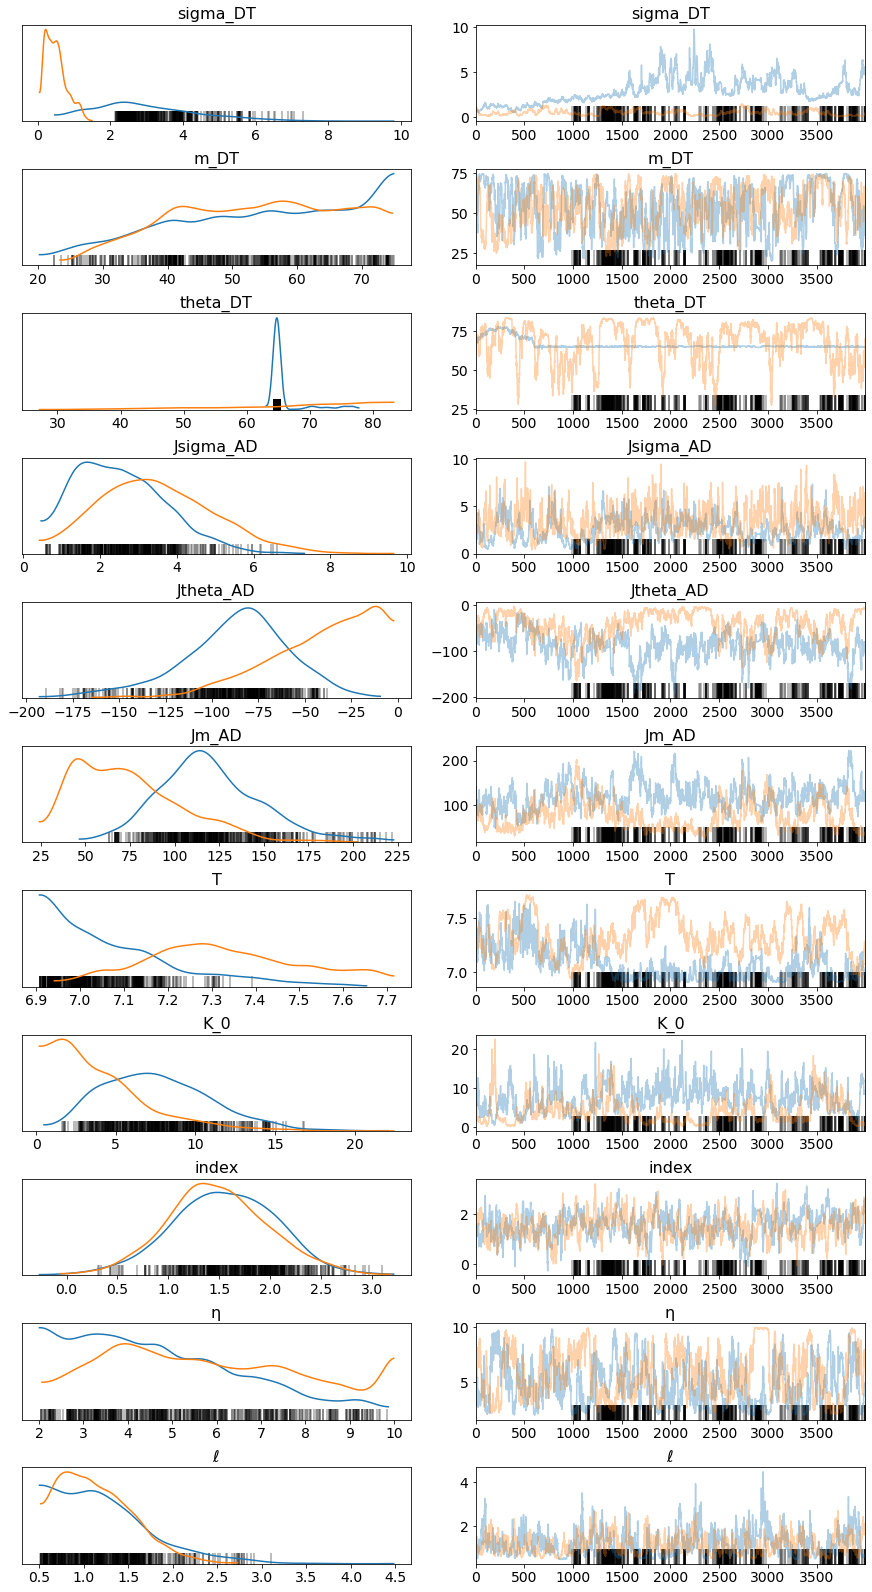

In [12]:
pm.traceplot(tracesimple, var_names=simplenames);

/home/malte/anaconda3/lib/python3.7/site-packages/arviz/plots/pairplot.py:219: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 9x9 grid
  SyntaxWarning,


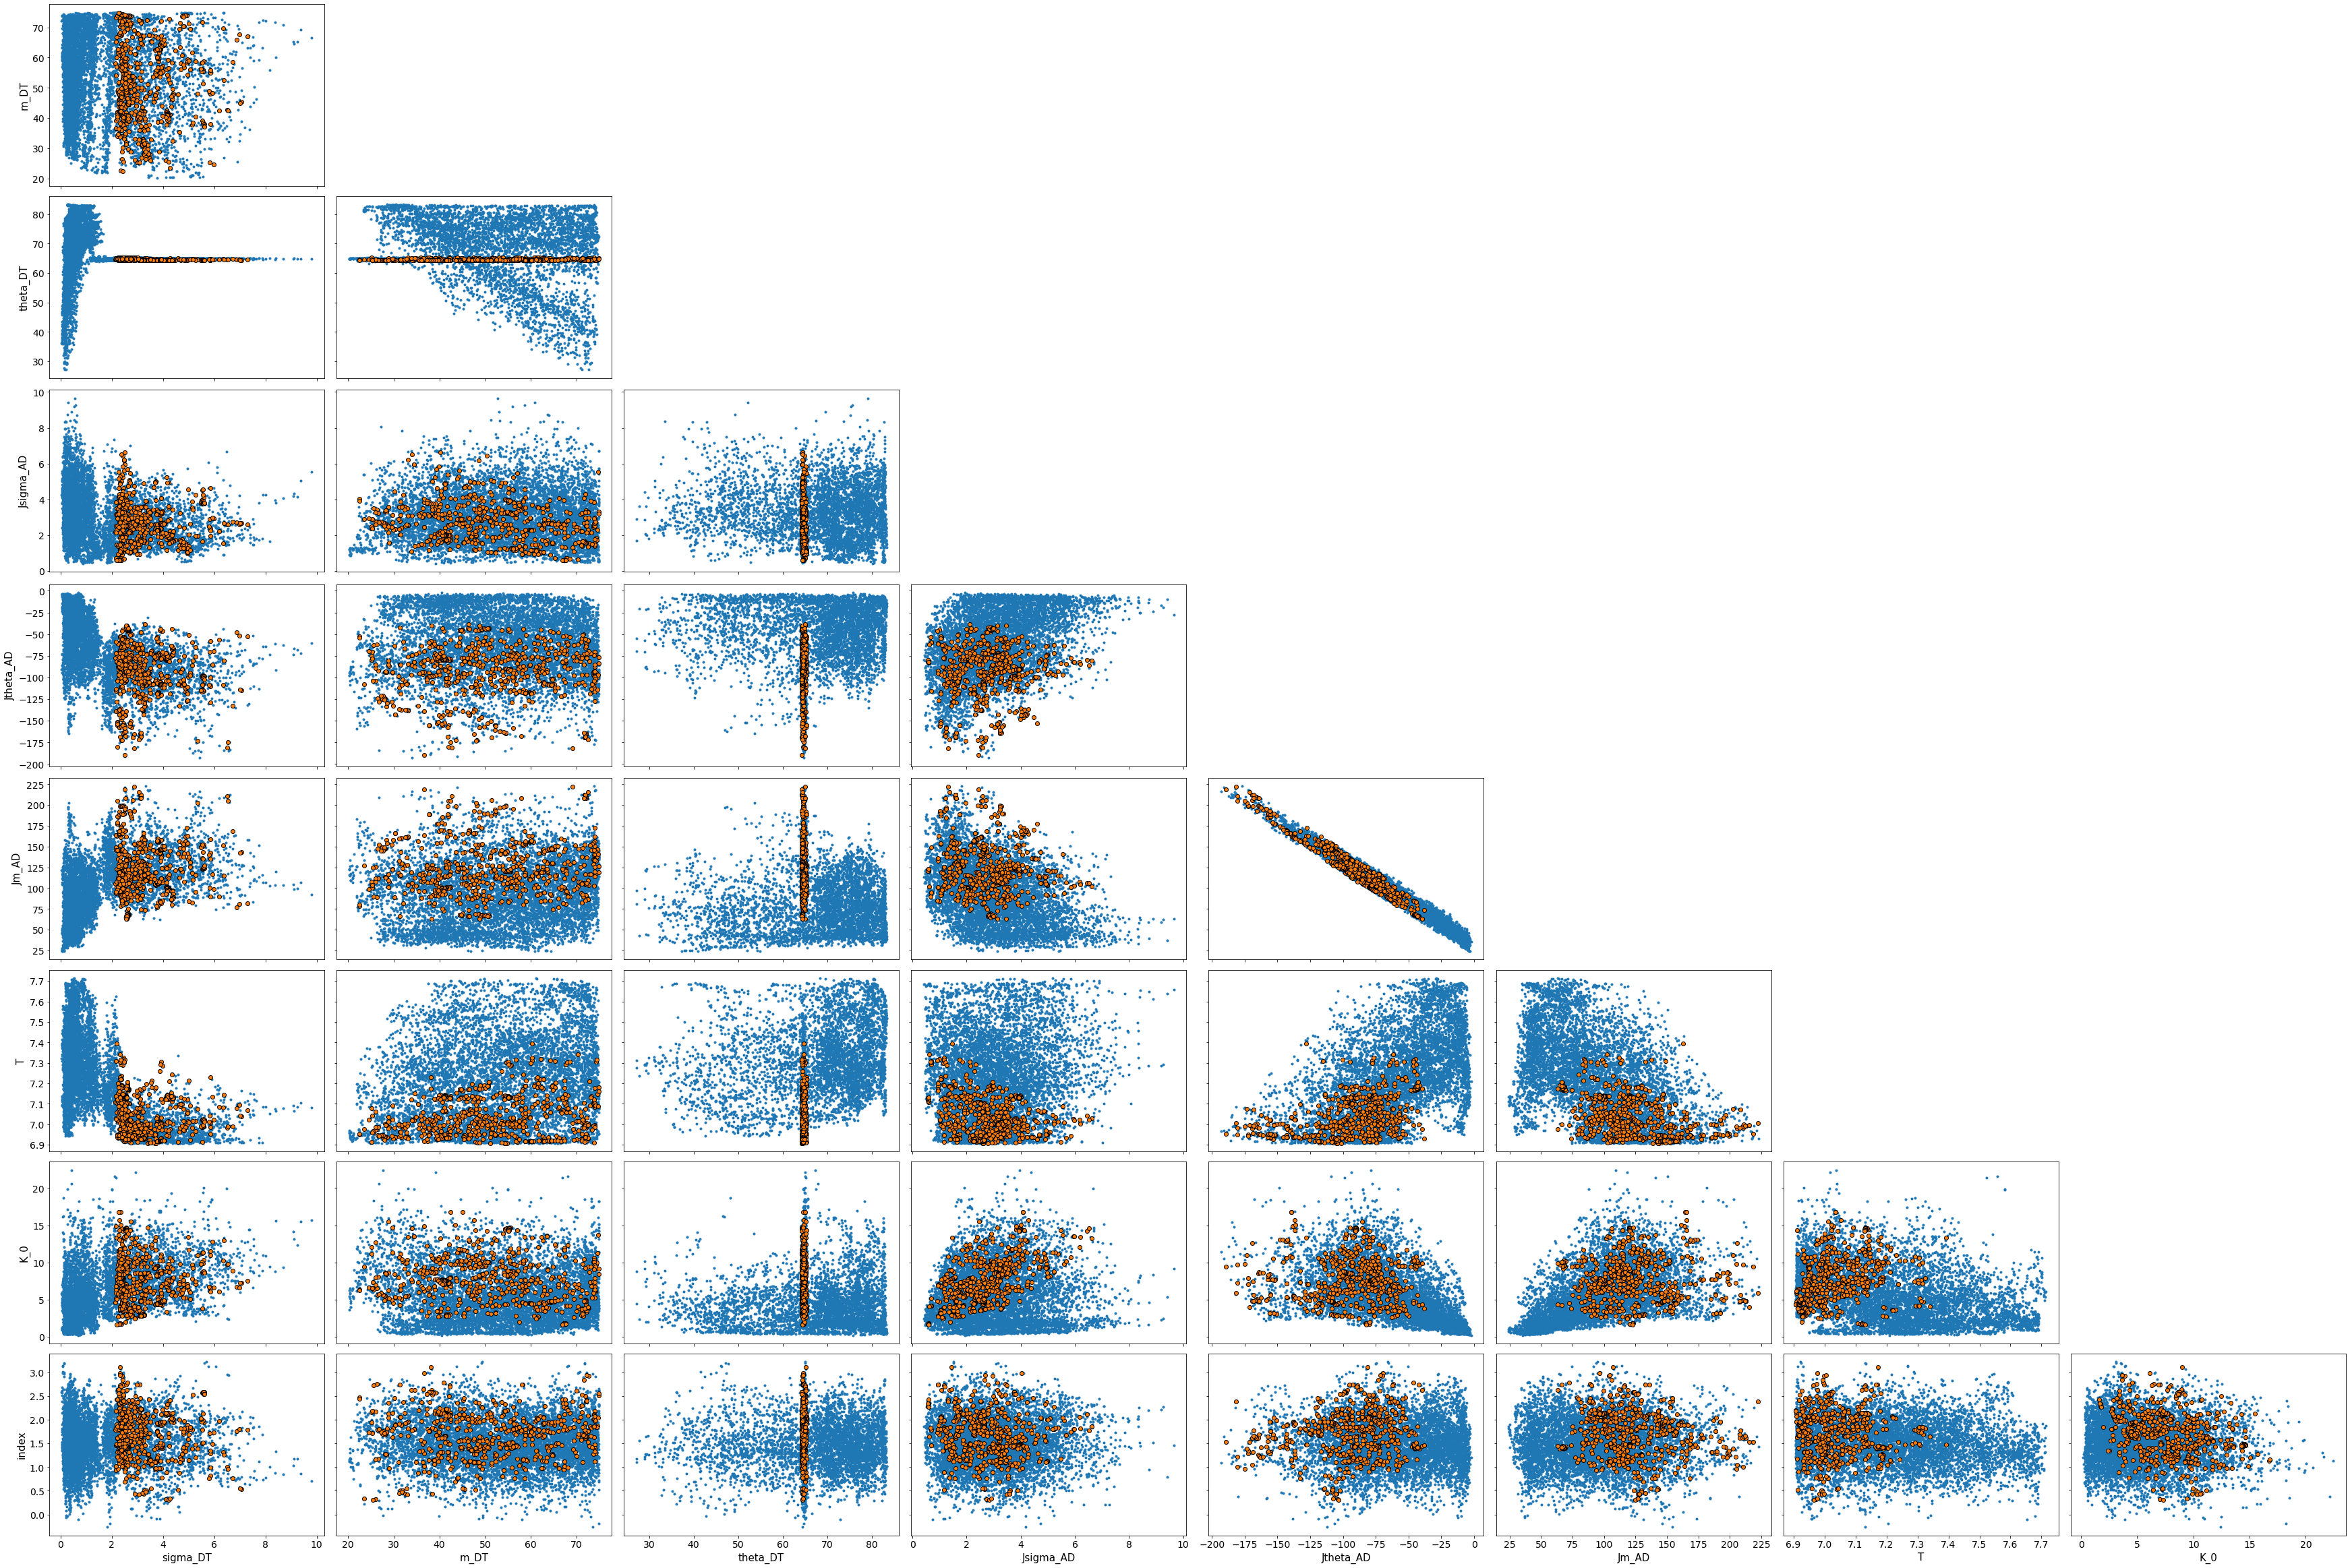

In [13]:
pm.pairplot(tracesimple, var_names=simplenames, divergences=True);

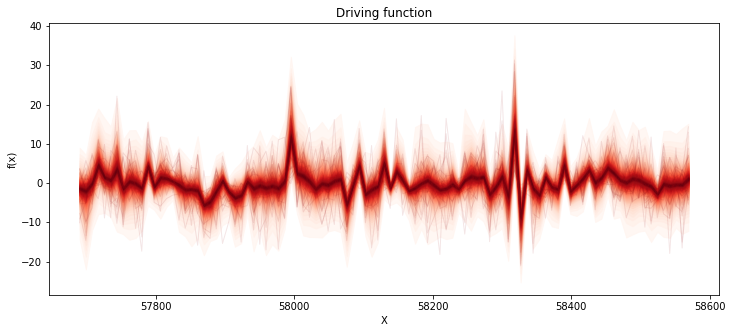

In [15]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, tracesimple["f"], Xf);

# plot the data and the true latent function
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("f(x)");
plt.title("Driving function");

In [12]:
n_new = 300
X_new = np.linspace(min(X_tot), max(X_tot), n_new)

# add the GP conditional to the model, given the new X values
with simpleconvmodel:
    f_J = gp.conditional("f_J", X_new)

# Sample from the GP conditional distribution
with simpleconvmodel:
    pred_samples = pm.sample_posterior_predictive(tracesimple, vars=[f_J], samples=1000)

/home/malte/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  2%|▏         | 22/1000 [00:01<01:12, 13.42it/s]/home/malte/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:49<00:00, 20.14it/s]


6.868430244405748


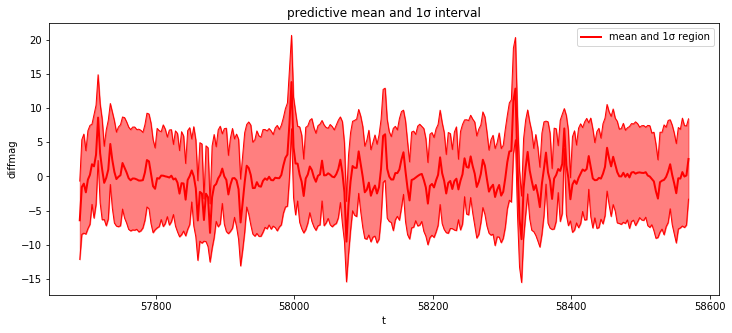

In [13]:
#Calculate the mean and standard deviation of the traces. 
mu = np.zeros(len(X_new))
sd = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu[i] = np.mean(pred_samples["f_J"][:,i])
    sd[i] = np.std(pred_samples["f_J"][:,i])

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)
#plt.errorbar(XJ,mu,sd,fmt='r.',label='Driving function value at data points')

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
#plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();
print(np.mean(sd))

In [16]:
print(summ.loc[:,'mean'])
#print(summ.loc[:])

sigma_DT      1.735
m_DT         53.410
theta_DT     66.814
Jsigma_AD     3.005
Jtheta_AD   -65.121
Jm_AD        97.101
T             7.205
K_0           5.757
index         1.511
η             5.298
ℓ             1.189
Name: mean, dtype: float64


In [18]:
nplot=2499
tau=np.linspace(-(XJ[-1]-XJ[0])/3,(XJ[-1]-XJ[0])/3,nplot)
sigma_DT=      1.735
m_DT     =    53.410
theta_DT  =   66.814
Jsigma_AD  =   3.005
Jtheta_AD   =-65.121
Jm_AD        =97.101
T             =np.exp(7.205)
K_0           =5.757
index         =1.511
#REMEMBER T is EXP

#Different wavelength for different bands, not a free paramter 
#REMIR filters in nm NEED DATASHEET
Jwav=1250.0 

#Define constants 
wav_0 = 1122.4#Reference wavelength in nm, use 500?
h = 6.626e-34#Plancks constant in J*s
c = 299792458.0#speed of light in m/s
k = 1.38e-23#Boltzmanns constant in J/K
    
#peak Black Body from uniform torus temperature
wav_peak = 2.898*10**6/T
b_max = h*c/(1e-9*wav_peak*k*T)
BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
#Universal lognormal for Dusty Torus 
exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
lognorm_DT = front_DT*np.exp(exp_DT)
where_are_NaNs1 = np.isnan(lognorm_DT)
lognorm_DT[where_are_NaNs1] = 0.0
    
#Dusty Torus transfer equation for J band
Jb = h*c/(1e-9*Jwav*k*T)
JBB = (1.0/( Jwav**5 * (np.exp(Jb) - 1.0) ))/BB_max
JPsi_DT = JBB*lognorm_DT
    
#Accretion Disk transfer equation for the J band
Jpowr = K_0*(Jwav/wav_0)**(index)    
Jexp_AD = -((np.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
Jlognorm_AD = Jfront_AD*np.exp(Jexp_AD)
where_are_NaNs2 = np.isnan(Jlognorm_AD)
Jlognorm_AD[where_are_NaNs2] = 0.0
JPsi_AD = Jpowr*Jlognorm_AD

#Full transfer equations
Jtransfer = JPsi_DT + JPsi_AD
    
#The convolutions
#filter needs to be odd so tau is odd
#Jconvol=np.convolve(mu,Jtransfer,'same')
    
#plt.errorbar(XJ, yJ, yerr=yJerr, fmt=".k", capsize=0, label='muK')
#plt.errorbar(XJ, Jconvol, yerr=sd[0:len(XJ)], fmt=".r", capsize=0, label='conv')
#plt.plot(tau, Jconvol, ":r", label="conv")
#plt.legend(fontsize=14)
#plt.xlabel("Time[d]")
#plt.ylabel("diffmag");
print(Jexp_AD)


[[        nan]
 [        nan]
 [        nan]
 ...
 [-0.09415586]
 [-0.09425057]
 [-0.09434527]]


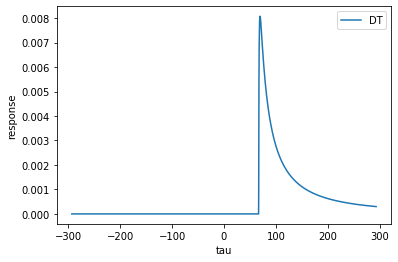

In [21]:
plt.plot(tau,JPsi_DT,label='DT')
#plt.plot(tau,JPsi_AD, label='AD')
#plt.plot(tau,Jtransfer,label='FULL')
plt.xlabel('tau')
plt.ylabel('response');
plt.legend();

In [18]:
def interpolate(x0, y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [55]:
#y0=np.linspace(0,10,10)
x0=np.linspace(0,10,100)
y = normal(x0,5.0,0.5) 
x=[4.5,5.8]
interpolate(x0,y,x)

array([0.48397   , 0.22356456])

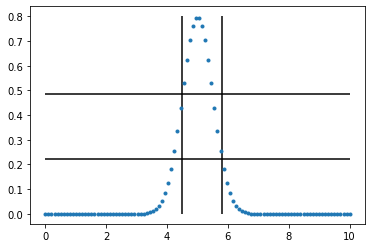

In [56]:
plt.plot(x0,y,'.')
plt.vlines(x,0,0.8)
plt.hlines(interpolate(x0,y,x),0,10)

In [ ]:
[]